## Importing necessary libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Standard plotly imports
#import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
#cufflinks.go_offline(connected=True)

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

## Hyperopt modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
import gc
print(os.listdir("../input"))

['train_identity.csv', 'train_transaction.csv', 'test_transaction.csv', 'test_identity.csv', 'sample_submission.csv']


# Importing train datasets

In [2]:
df_id = pd.read_csv("../input/train_identity.csv")
df_trans = pd.read_csv("../input/train_transaction.csv")

In [3]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def CalcOutliers(df_num): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

In [4]:
## REducing memory
df_trans = reduce_mem_usage(df_trans)
df_id = reduce_mem_usage(df_id)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)


To see the output of the Resume Table, click to see the output 

# Knowing the data

In [5]:
resumetable(df_trans)[:25]

Dataset Shape: (590540, 394)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int32,0,590540,2987000,2987001,2987002,19.17
1,isFraud,int8,0,2,0,0,0,0.22
2,TransactionDT,int32,0,573349,86400,86401,86469,19.11
3,TransactionAmt,float16,0,8195,68.5,29,59,8.10
4,ProductCD,object,0,5,W,W,W,1.28
5,card1,int16,0,13553,13926,2755,4663,9.97
6,card2,float16,8933,500,nan,404,490,6.32
7,card3,float16,1565,114,150,150,150,0.68
8,card4,object,1577,4,discover,mastercard,visa,1.09
9,card5,float16,4259,119,142,102,166,2.66


# Target Distribution

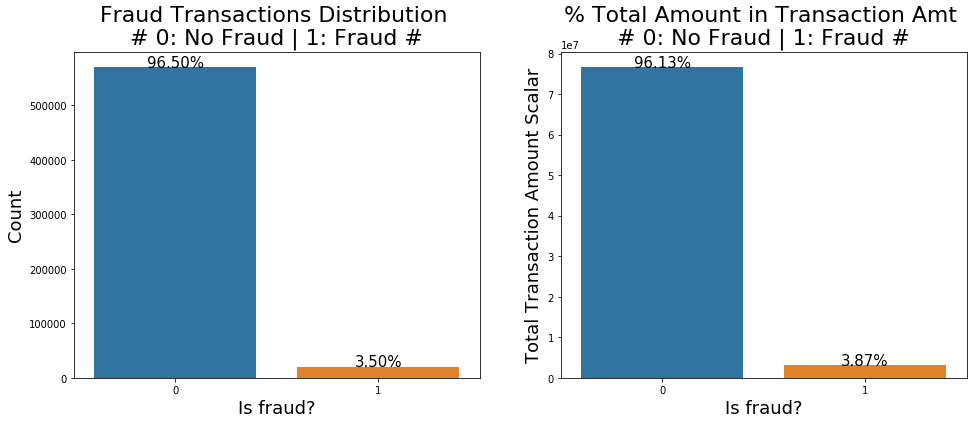

In [6]:
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
total = len(df_trans)
total_amt = df_trans.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(16,6))

plt.subplot(121)
g = sns.countplot(x='isFraud', data=df_trans, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g.set_xlabel("Is fraud?", fontsize=18)
g.set_ylabel('Count', fontsize=18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

perc_amt = (df_trans.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g1.set_xlabel("Is fraud?", fontsize=18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize=18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15) 
    
plt.show()

In [7]:
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
print("Transaction Amounts Quantiles:")
print(df_trans['TransactionAmt'].quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99]))

Transaction Amounts Quantiles:
0.010       9.242188
0.025      14.500000
0.100      25.953125
0.250      43.312500
0.500      68.750000
0.750     125.000000
0.900     275.250000
0.975     648.262500
0.990    1104.000000
Name: TransactionAmt, dtype: float64


In [10]:
CalcOutliers(df_trans['TransactionAmt'])

Identified lowest outliers: 0
Identified upper outliers: 10097
Total outlier observations: 10097
Non-outlier observations: 580443
Total percentual of Outliers:  1.7395


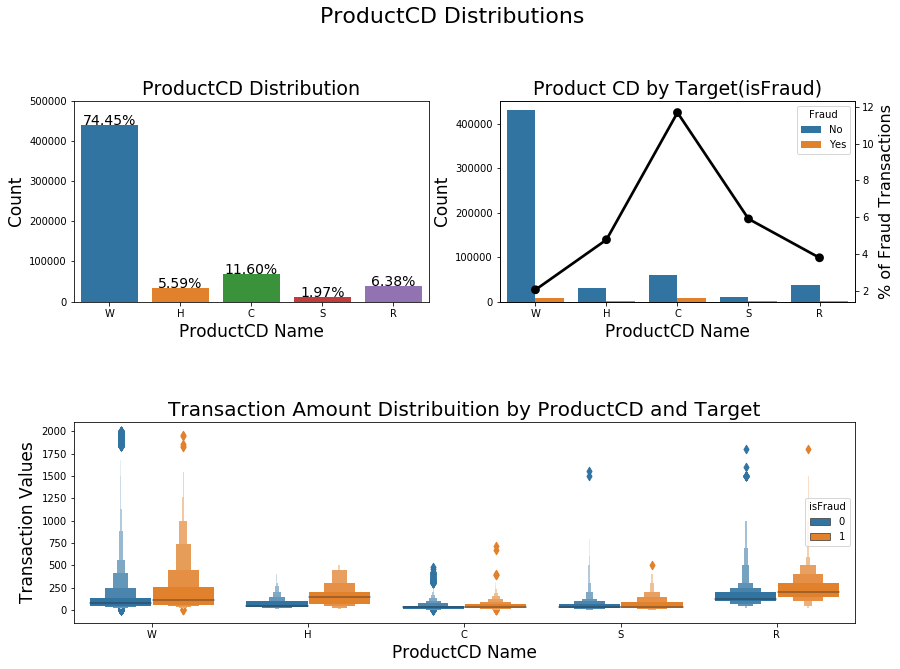

In [11]:
tmp = pd.crosstab(df_trans['ProductCD'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('ProductCD Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='ProductCD', data=df_trans)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

g.set_title("ProductCD Distribution", fontsize=19)
g.set_xlabel("ProductCD Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g.set_ylim(0,500000)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=df_trans)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)

g1.set_title("Product CD by Target(isFraud)", fontsize=19)
g1.set_xlabel("ProductCD Name", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='ProductCD', y='TransactionAmt', hue='isFraud', 
              data=df_trans[df_trans['TransactionAmt'] <= 2000] )
g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("ProductCD Name", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

In [12]:
## Knowning the Card Features
resumetable(df_trans[['card1', 'card2', 'card3','card4', 'card5', 'card6']])

Dataset Shape: (590540, 6)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,card1,int16,0,13553,13926,2755,4663,9.97
1,card2,float16,8933,500,nan,404,490,6.32
2,card3,float16,1565,114,150,150,150,0.68
3,card4,object,1577,4,discover,mastercard,visa,1.09
4,card5,float16,4259,119,142,102,166,2.66
5,card6,object,1571,4,credit,credit,debit,0.82


In [13]:
print("Card Features Quantiles: ")
print(df_trans[['card1', 'card2', 'card3', 'card5']].quantile([0.01, .025, .1, .25, .5, .75, .975, .99]))

Card Features Quantiles: 
         card1  card2  card3  card5
0.010   1338.0  100.0  144.0  102.0
0.025   1675.0  111.0  150.0  102.0
0.100   2803.0  111.0  150.0  126.0
0.250   6019.0  214.0  150.0  166.0
0.500   9678.0  361.0  150.0  226.0
0.750  14184.0  512.0  150.0  226.0
0.975  18018.0  583.0  185.0  226.0
0.990  18238.0  583.0  185.0  226.0


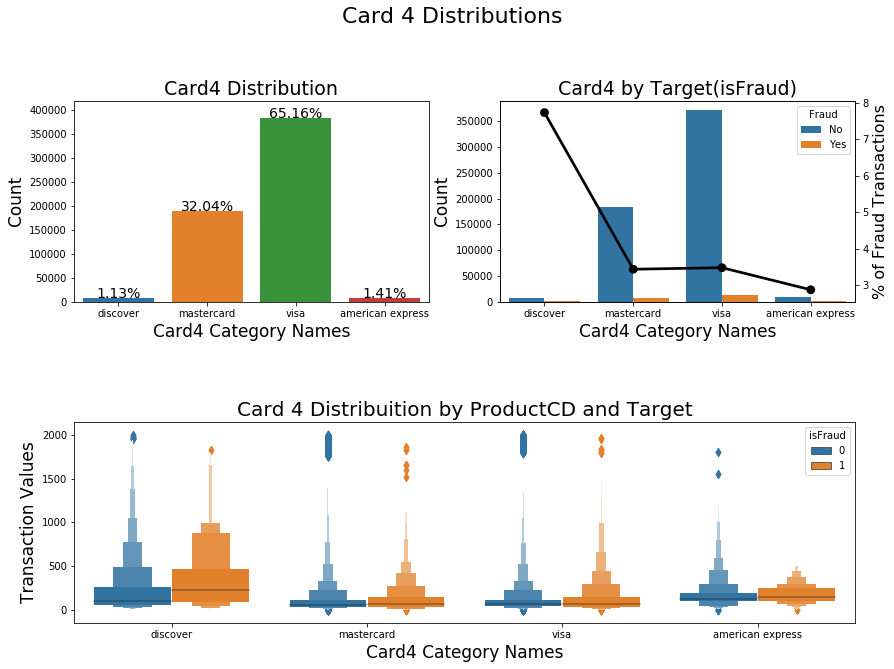

In [16]:
tmp = pd.crosstab(df_trans['card4'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 4 Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='card4', data=df_trans)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card4 Distribution", fontsize=19)
g.set_ylim(0,420000)
g.set_xlabel("Card4 Category Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 


plt.subplot(222)
g1 = sns.countplot(x='card4', hue='isFraud', data=df_trans)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card4', y='Fraud', data=tmp, 
                   color='black', legend=False, 
                   order=['discover', 'mastercard', 'visa', 'american express'])
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card4 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Card4 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='card4', y='TransactionAmt', hue='isFraud', 
              data=df_trans[df_trans['TransactionAmt'] <= 2000] )
g3.set_title("Card 4 Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("Card4 Category Names", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

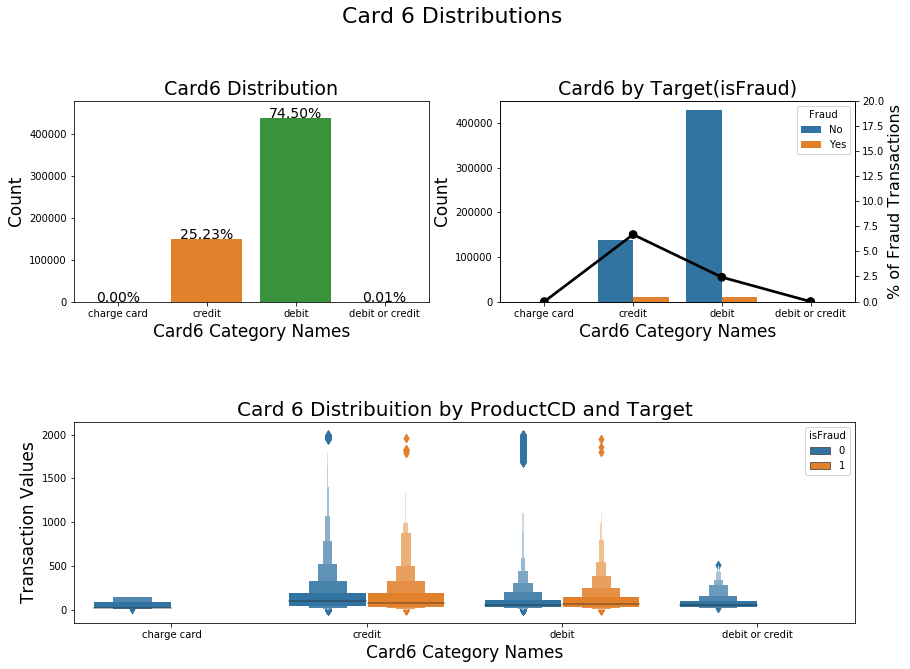

In [17]:
tmp = pd.crosstab(df_trans['card6'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 6 Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='card6', data=df_trans, order=list(tmp.card6.values))
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card6 Distribution", fontsize=19)
g.set_ylim(0,480000)
g.set_xlabel("Card6 Category Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='card6', hue='isFraud', data=df_trans, order=list(tmp.card6.values))
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card6', y='Fraud', data=tmp, order=list(tmp.card6.values),
                   color='black', legend=False, )
gt.set_ylim(0,20)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card6 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Card6 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='card6', y='TransactionAmt', hue='isFraud', order=list(tmp.card6.values),
              data=df_trans[df_trans['TransactionAmt'] <= 2000] )
g3.set_title("Card 6 Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("Card6 Category Names", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

In [18]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    df_trans[col] = df_trans[col].fillna("Miss")
    
def ploting_dist_ratio(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(20,5))
    plt.suptitle(f'{col} Distributions ', fontsize=22)

    plt.subplot(121)
    g = sns.countplot(x=col, data=df, order=list(tmp[col].values))
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
    g.set_title(f"{col} Distribution\nCound and %Fraud by each category", fontsize=18)
    g.set_ylim(0,400000)
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,20)
    gt.set_ylabel("% of Fraud Transactions", fontsize=16)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    for p in gt.patches:
        height = p.get_height()
        gt.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=14) 
        
    perc_amt = (df_trans.groupby(['isFraud',col])['TransactionAmt'].sum() / total_amt * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.subplot(122)
    g1 = sns.boxplot(x=col, y='TransactionAmt', hue='isFraud', 
                     data=df[df['TransactionAmt'] <= lim], order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,5)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g1.set_title(f"{col} by Transactions dist", fontsize=18)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Amount(U$)", fontsize=16)
        
    plt.subplots_adjust(hspace=.4, wspace = 0.35, top = 0.80)
    
    plt.show()


In [20]:
print("Card Features Quantiles: ")
print(df_trans[['addr1', 'addr2']].quantile([0.01, .025, .1, .25, .5, .75, .90,.975, .99]))

Card Features Quantiles: 
       addr1  addr2
0.010  123.0   87.0
0.025  123.0   87.0
0.100  177.0   87.0
0.250  204.0   87.0
0.500  299.0   87.0
0.750  330.0   87.0
0.900  441.0   87.0
0.975  498.0   87.0
0.990  512.0   87.0


In [21]:
df_trans.loc[df_trans.addr1.isin(df_trans.addr1.value_counts()[df_trans.addr1.value_counts() <= 5000 ].index), 'addr1'] = "Others"
df_trans.loc[df_trans.addr2.isin(df_trans.addr2.value_counts()[df_trans.addr2.value_counts() <= 50 ].index), 'addr2'] = "Others"

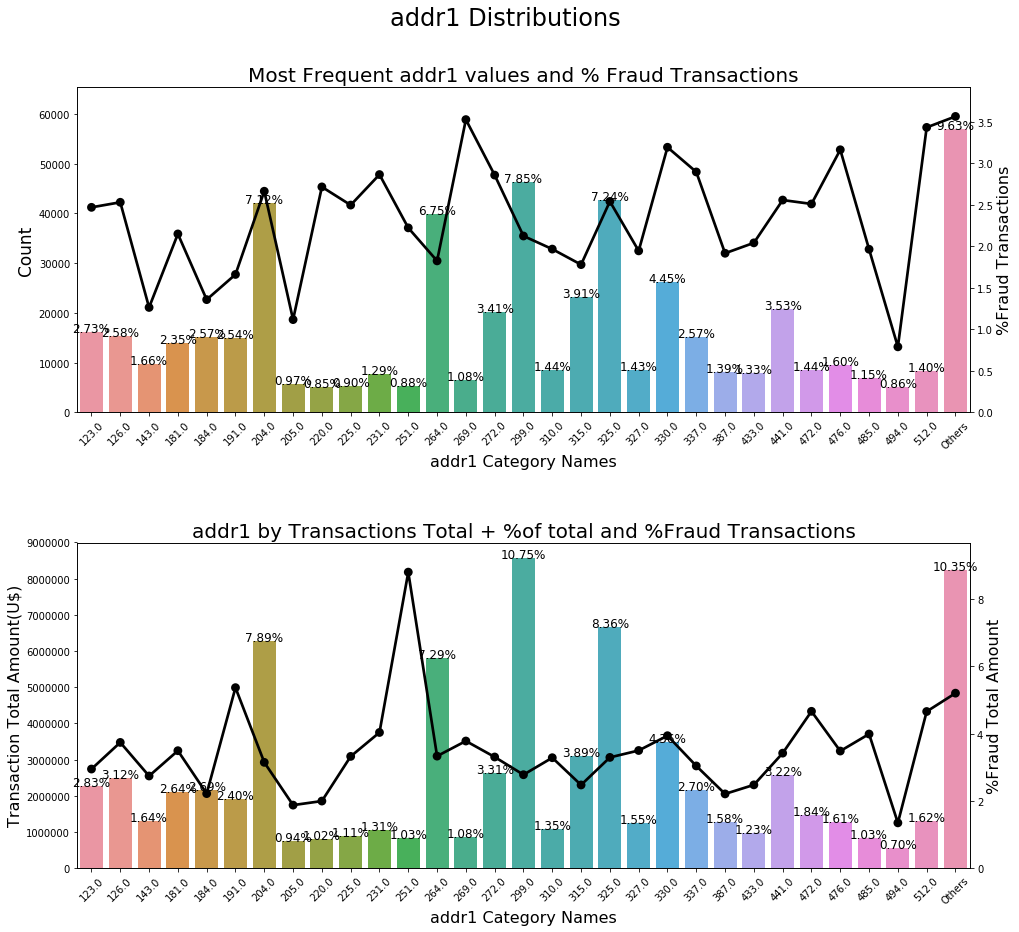

In [22]:
 def ploting_cnt_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    g.set_ylim(0,max(sizes)*1.15)
    
    #########################################################################
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
                / df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    g1 = sns.barplot(x=col, y='TransactionAmt', 
                       data=amt, 
                       order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, 
                        order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title(f"{col} by Transactions Total + %of total and %Fraud Transactions", fontsize=20)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)    
    
    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12) 
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()
    
ploting_cnt_amt(df_trans, 'addr1')

In [24]:
df_trans.loc[df_trans['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'

df_trans.loc[df_trans['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'
df_trans.loc[df_trans['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
df_trans.loc[df_trans.P_emaildomain.isin(df_trans.P_emaildomain\
                                         .value_counts()[df_trans.P_emaildomain.value_counts() <= 500 ]\
                                         .index), 'P_emaildomain'] = "Others"
df_trans.P_emaildomain.fillna("NoInf", inplace=True)

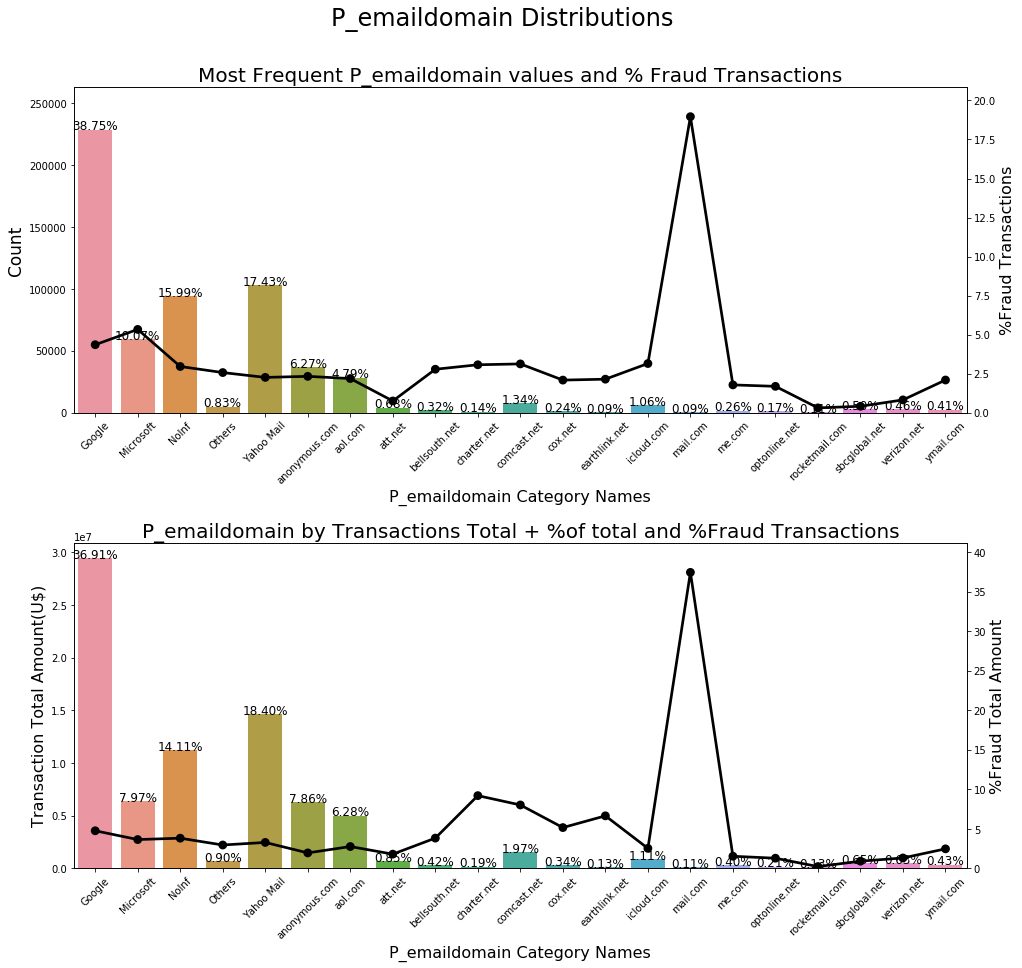

In [25]:
ploting_cnt_amt(df_trans, 'P_emaildomain')

In [26]:
df_trans.loc[df_trans['R_emaildomain'].isin(['gmail.com', 'gmail']),'R_emaildomain'] = 'Google'

df_trans.loc[df_trans['R_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                             'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                             'yahoo.es']), 'R_emaildomain'] = 'Yahoo Mail'
df_trans.loc[df_trans['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                             'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                             'outlook.es', 'live.com', 'live.fr',
                                             'hotmail.fr']), 'R_emaildomain'] = 'Microsoft'
df_trans.loc[df_trans.R_emaildomain.isin(df_trans.R_emaildomain\
                                         .value_counts()[df_trans.R_emaildomain.value_counts() <= 300 ]\
                                         .index), 'R_emaildomain'] = "Others"
df_trans.R_emaildomain.fillna("NoInf", inplace=True)

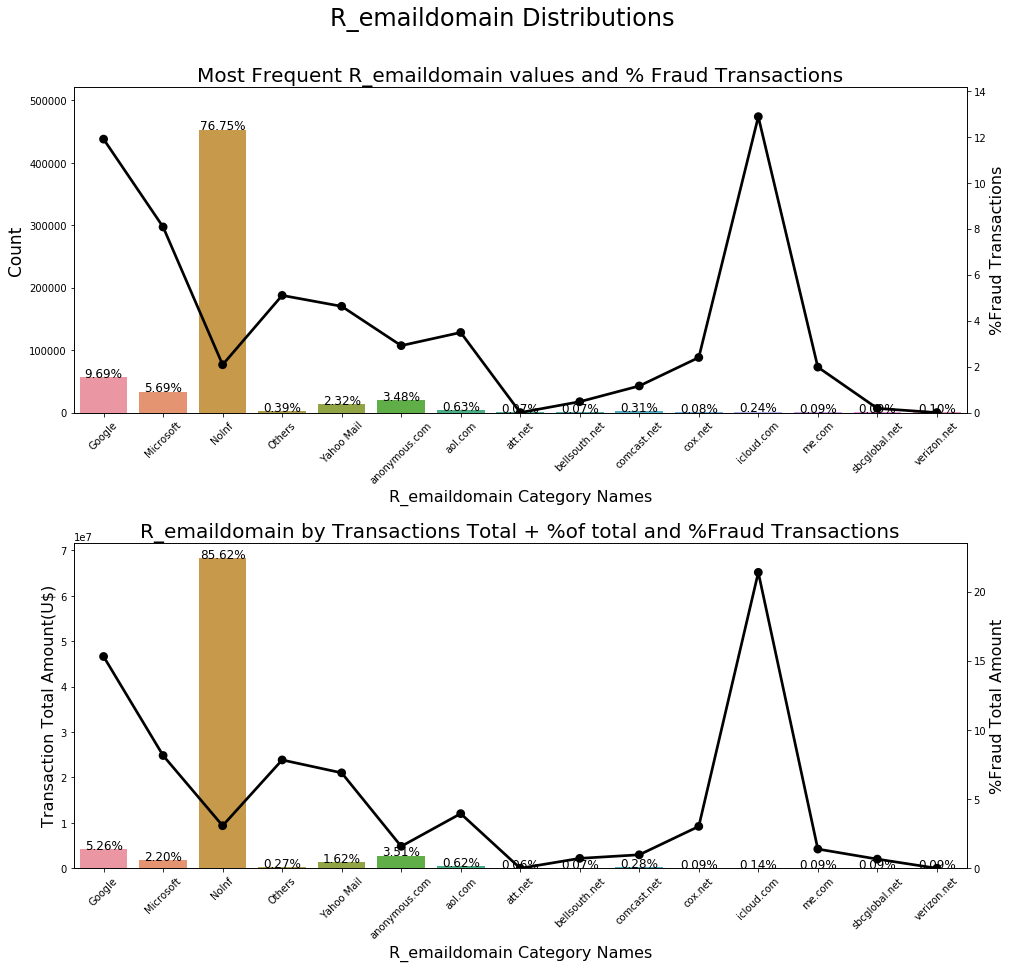

In [27]:
ploting_cnt_amt(df_trans, 'R_emaildomain')

In [28]:
resumetable(df_trans[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']])

Dataset Shape: (590540, 14)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,C1,float16,0,1495,1.0,1.0,1.0,2.72
1,C2,float16,0,1167,1.0,1.0,1.0,2.75
2,C3,float16,0,27,0.0,0.0,0.0,0.04
3,C4,float16,0,1223,0.0,0.0,0.0,1.12
4,C5,float16,0,319,0.0,0.0,0.0,2.06
5,C6,float16,0,1291,1.0,1.0,1.0,2.52
6,C7,float16,0,1069,0.0,0.0,0.0,0.71
7,C8,float16,0,1130,0.0,0.0,0.0,1.25
8,C9,float16,0,205,1.0,0.0,1.0,2.62
9,C10,float16,0,1122,0.0,0.0,0.0,1.23


In [29]:
df_trans[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']].describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,590540.0,590540.0,590540.000000,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0
mean,NaN,NaN,0.005650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.150635,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
min,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
50%,1.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0
75%,3.0,3.0,0.000000,0.0,1.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,12.0,2.0
max,4684.0,5692.0,26.000000,2252.0,349.0,2252.0,2256.0,3332.0,210.0,3256.0,3188.0,3188.0,2918.0,1429.0


In [30]:
df_trans.loc[df_trans.C1.isin(df_trans.C1\
                              .value_counts()[df_trans.C1.value_counts() <= 400 ]\
                              .index), 'C1'] = "Others"

In [34]:
# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100400#latest-579480
import datetime

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
df_trans["Date"] = df_trans['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

df_trans['_Weekdays'] = df_trans['Date'].dt.dayofweek
df_trans['_Hours'] = df_trans['Date'].dt.hour
df_trans['_Days'] = df_trans['Date'].dt.day

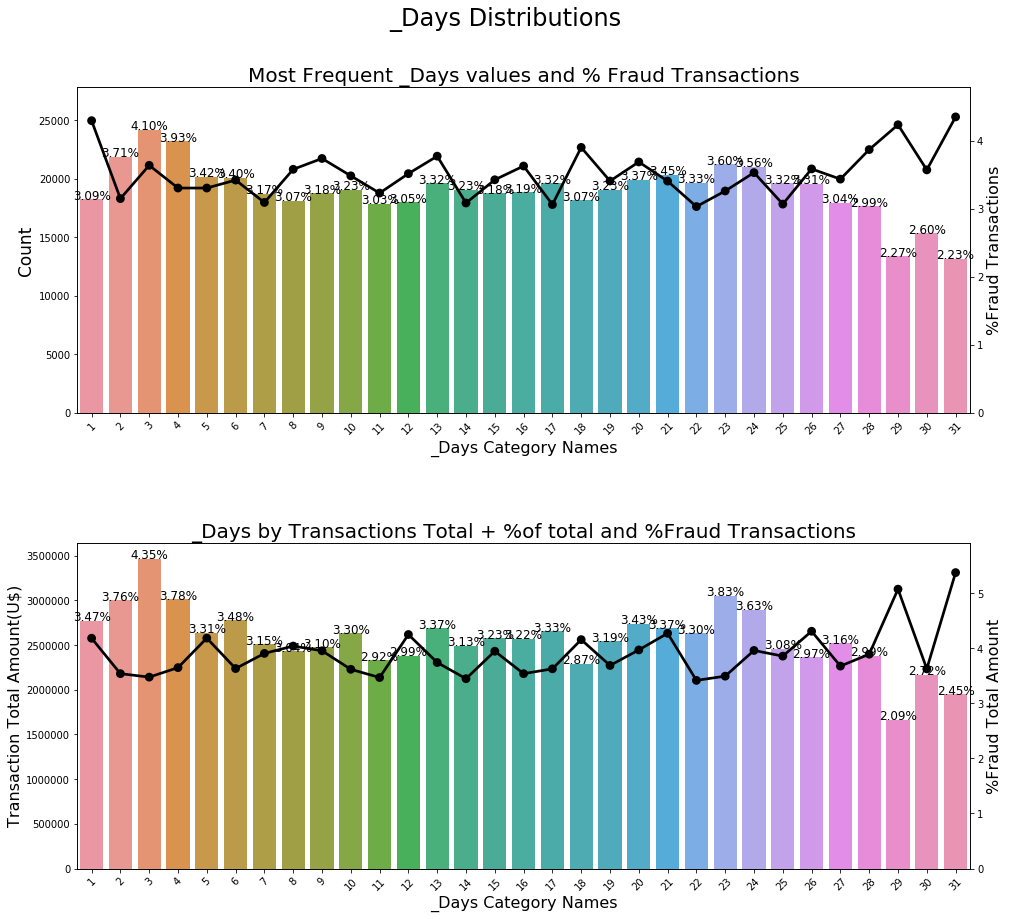

In [35]:
ploting_cnt_amt(df_trans, '_Days')

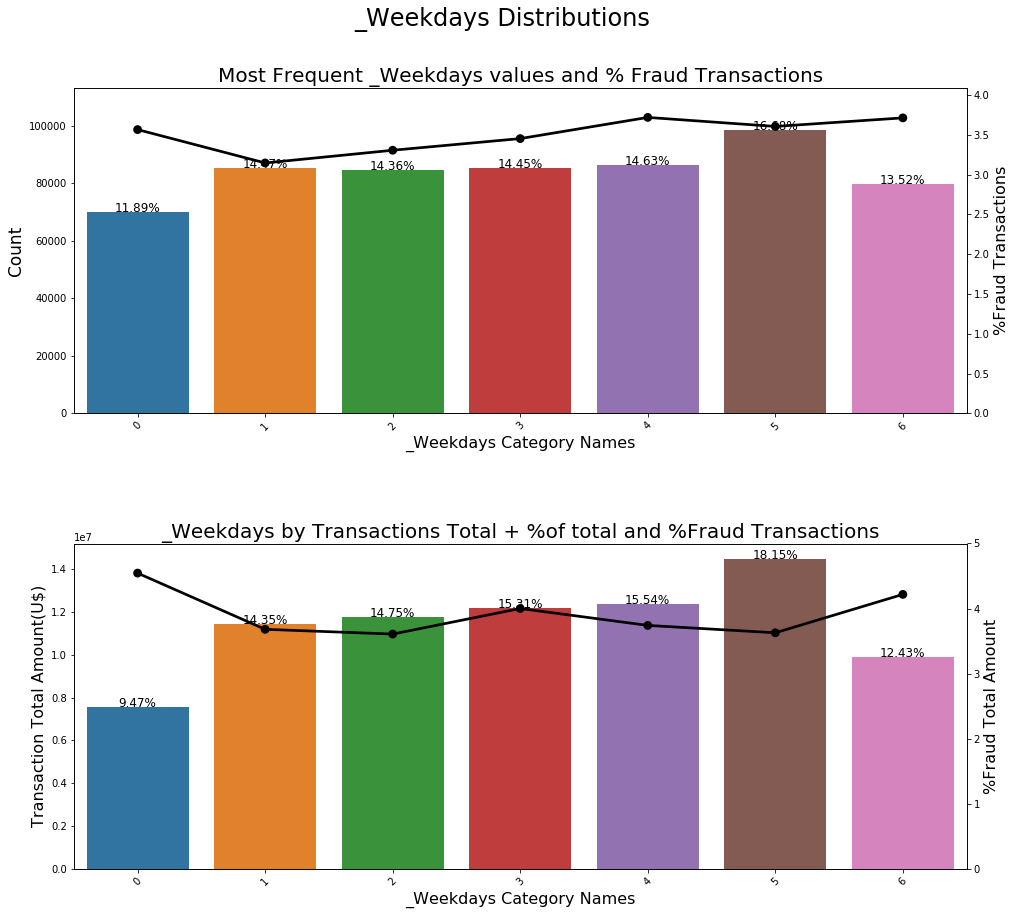

In [36]:
ploting_cnt_amt(df_trans, '_Weekdays')

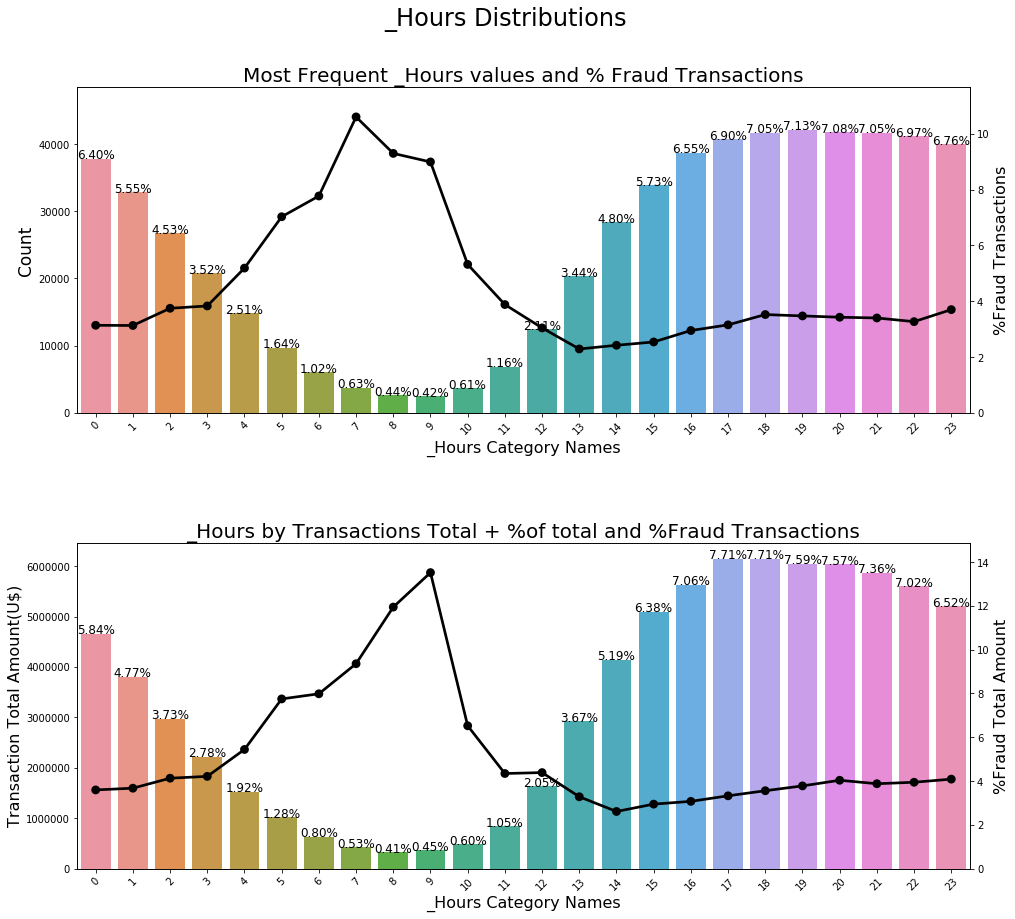

In [37]:
ploting_cnt_amt(df_trans, '_Hours')

In [40]:
df_id[['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18',
       'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']].describe(include='all')

,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
count,144233,127320.0,80044.0,140985,129340,139369.0,4.511300e+04,139318.0,139261.0,5159.000000,...,140978,77565,140282,77586.0,73289,77805,140985,140985,140985,140985
unique,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,NaN,...,2,75,130,NaN,260,4,2,2,2,2
top,NotFound,NaN,NaN,Found,Found,NaN,NaN,NaN,NaN,NaN,...,Found,Windows 10,chrome 63.0,NaN,1920x1080,match_status:2,T,F,T,F
freq,123025,NaN,NaN,67728,66324,NaN,NaN,NaN,NaN,NaN,...,74926,21155,22000,NaN,16874,60011,77814,134066,110452,73922
mean,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN,inf,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,0.0,NaN,NaN,NaN,0.0,1.561523e+00,NaN,NaN,inf,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,10.0,-660.0,NaN,NaN,100.0,1.000000e+01,100.0,100.0,100.000000,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,49.0,-360.0,NaN,NaN,166.0,1.300000e+01,266.0,256.0,252.000000,...,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,52.0,-300.0,NaN,NaN,166.0,1.500000e+01,341.0,472.0,252.000000,...,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,52.0,-300.0,NaN,NaN,225.0,1.500000e+01,427.0,533.0,486.500000,...,NaN,NaN,NaN,32.0,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df_train = df_trans.merge(df_id, how='left', left_index=True, right_index=True)

In [42]:
def cat_feat_ploting(df, col):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(14,10))
    plt.suptitle(f'{col} Distributions', fontsize=22)

    plt.subplot(221)
    g = sns.countplot(x=col, data=df, order=tmp[col].values)
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

    g.set_title(f"{col} Distribution", fontsize=19)
    g.set_xlabel(f"{col} Name", fontsize=17)
    g.set_ylabel("Count", fontsize=17)
    # g.set_ylim(0,500000)
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=14) 

    plt.subplot(222)
    g1 = sns.countplot(x=col, hue='isFraud', data=df, order=tmp[col].values)
    plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
    gt = g1.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, color='black', order=tmp[col].values, legend=False)
    gt.set_ylabel("% of Fraud Transactions", fontsize=16)

    g1.set_title(f"{col} by Target(isFraud)", fontsize=19)
    g1.set_xlabel(f"{col} Name", fontsize=17)
    g1.set_ylabel("Count", fontsize=17)

    plt.subplot(212)
    g3 = sns.boxenplot(x=col, y='TransactionAmt', hue='isFraud', 
                       data=df[df['TransactionAmt'] <= 2000], order=tmp[col].values )
    g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=20)
    g3.set_xlabel("ProductCD Name", fontsize=17)
    g3.set_ylabel("Transaction Values", fontsize=17)

    plt.subplots_adjust(hspace = 0.4, top = 0.85)

    plt.show()

## Ploting columns with few unique values

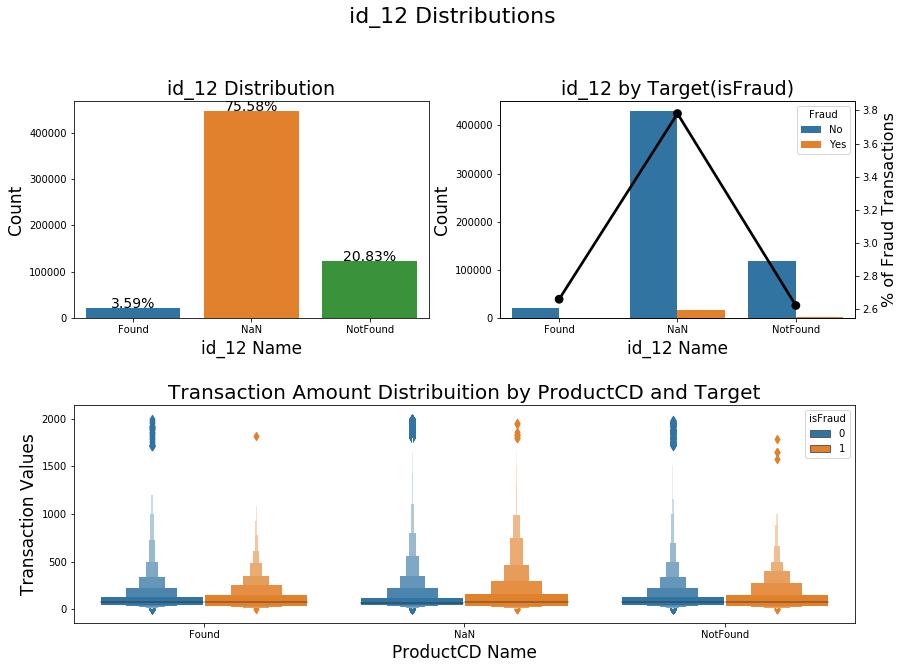

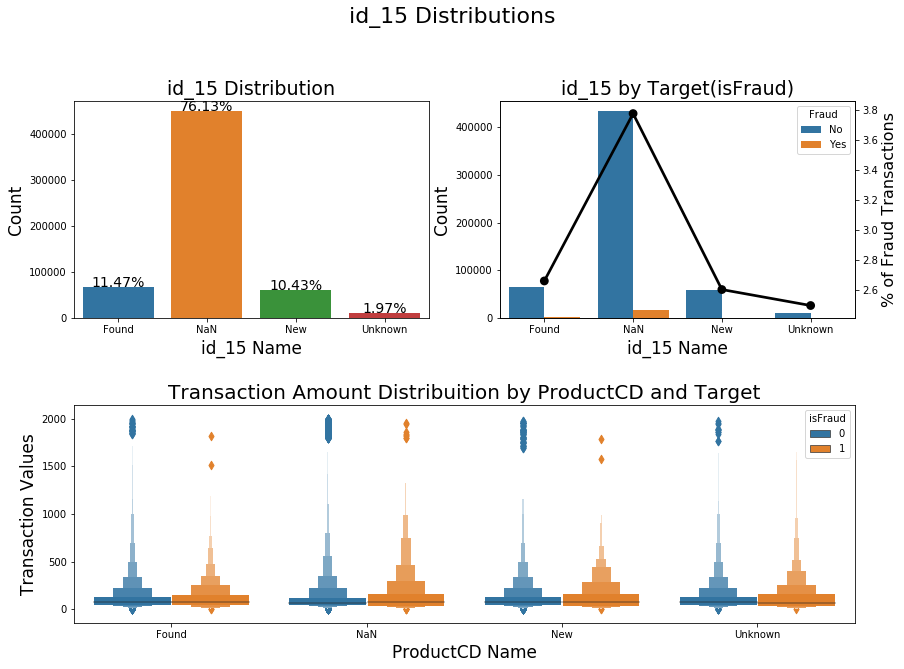

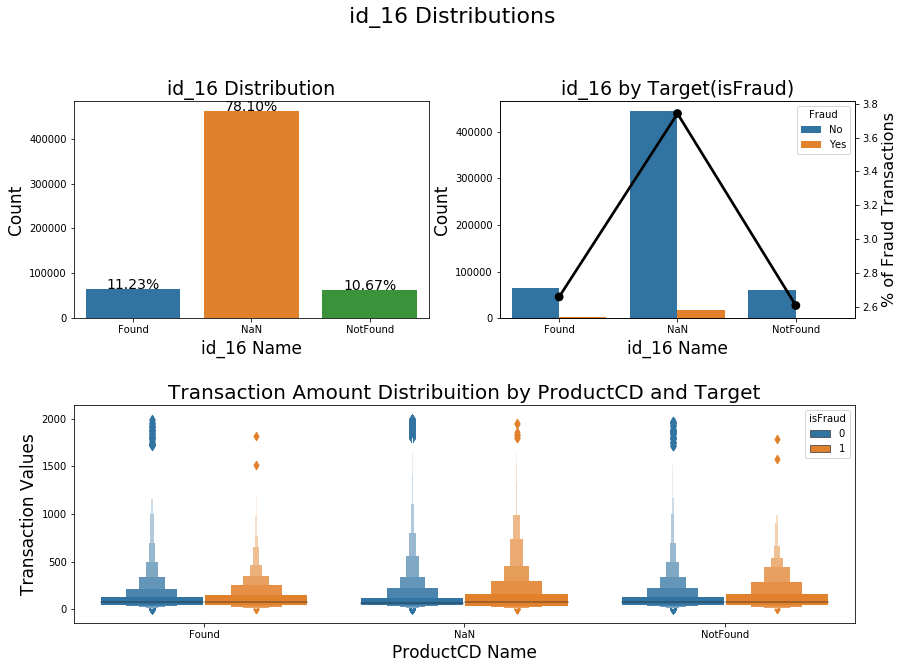

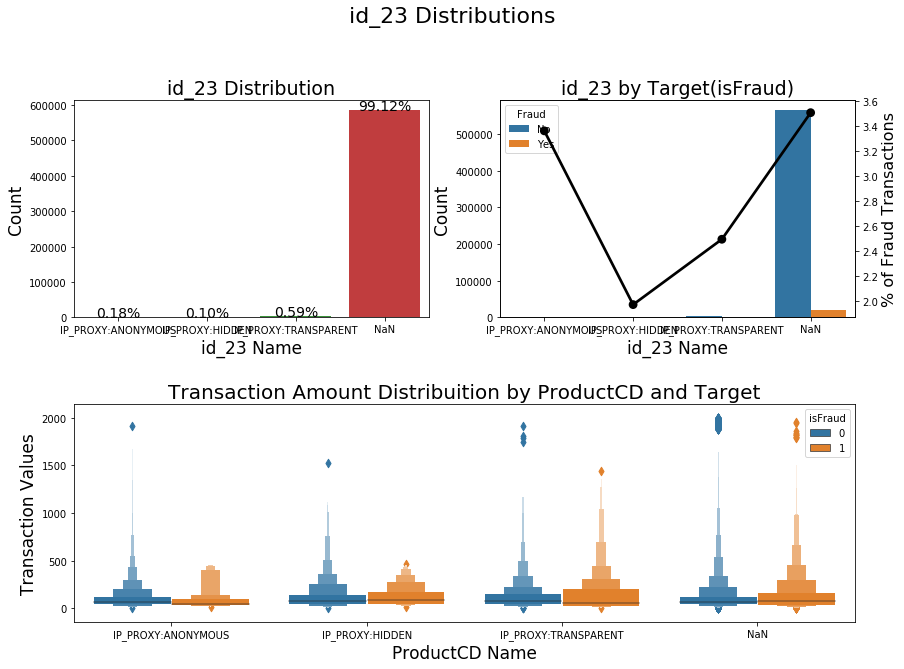

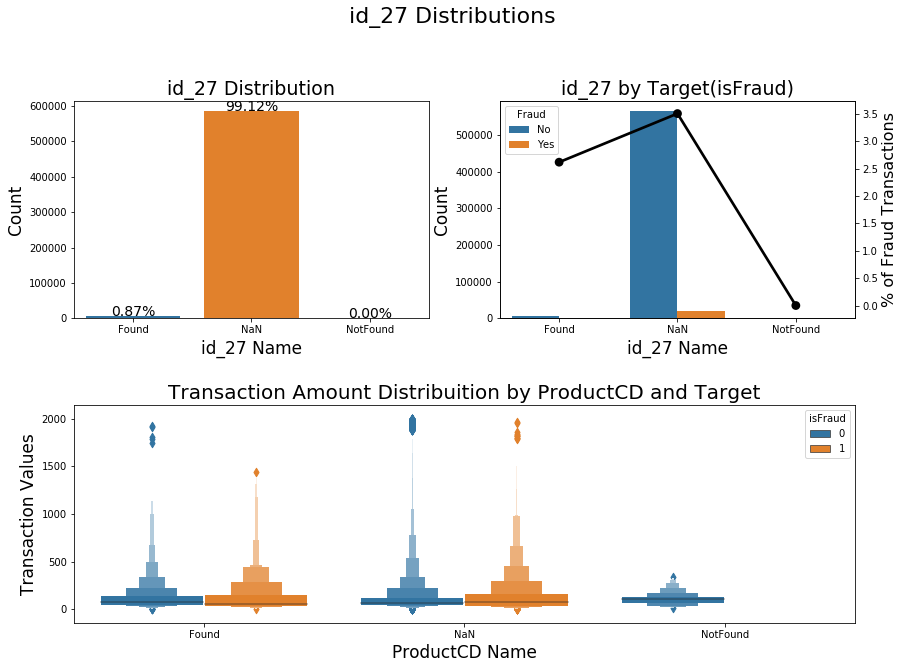

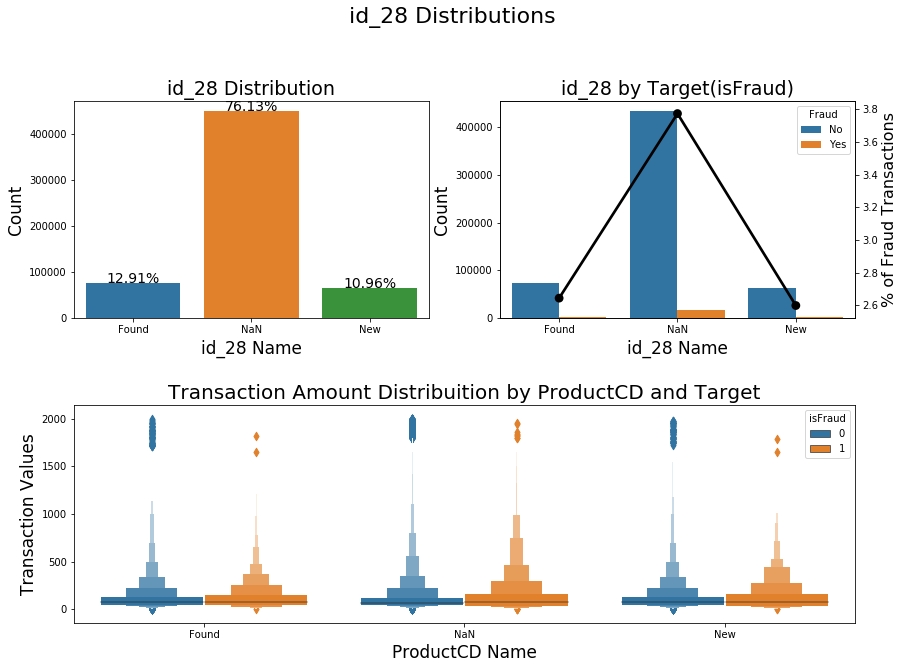

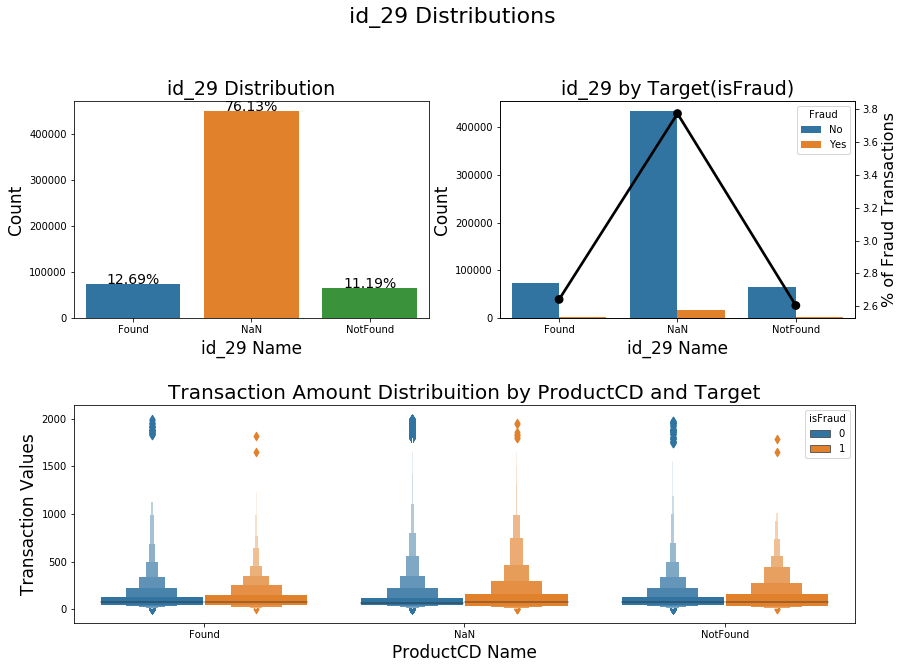

In [43]:
for col in ['id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29']:
    df_train[col] = df_train[col].fillna('NaN')
    cat_feat_ploting(df_train, col)

In [44]:
df_train.loc[df_train['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
df_train.loc[df_train['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
df_train.loc[df_train['id_30'].str.contains('Mac OS', na=False), 'id_30'] = 'Mac'
df_train.loc[df_train['id_30'].str.contains('Android', na=False), 'id_30'] = 'Android'
df_train['id_30'].fillna("NAN", inplace=True)

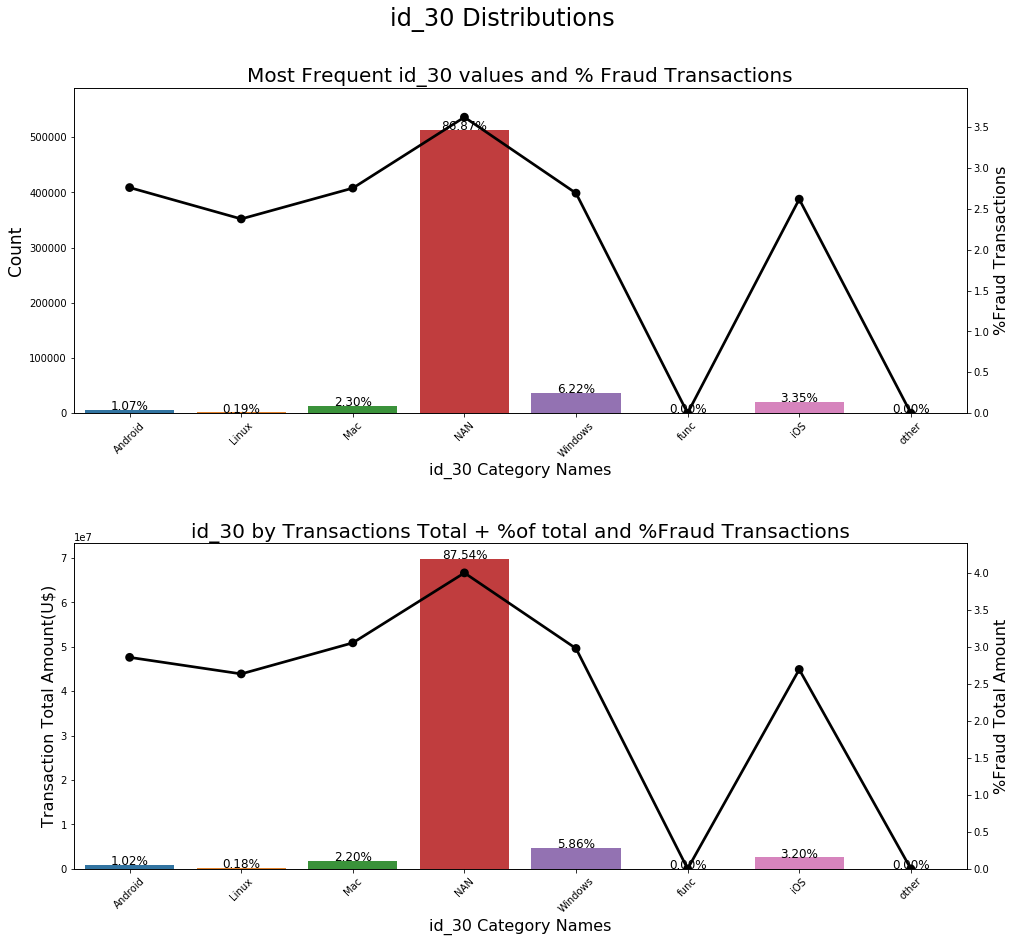

In [45]:
ploting_cnt_amt(df_train, 'id_30')

In [46]:
df_train.loc[df_train['id_31'].str.contains('chrome', na=False), 'id_31'] = 'Chrome'
df_train.loc[df_train['id_31'].str.contains('firefox', na=False), 'id_31'] = 'Firefox'
df_train.loc[df_train['id_31'].str.contains('safari', na=False), 'id_31'] = 'Safari'
df_train.loc[df_train['id_31'].str.contains('edge', na=False), 'id_31'] = 'Edge'
df_train.loc[df_train['id_31'].str.contains('ie', na=False), 'id_31'] = 'IE'
df_train.loc[df_train['id_31'].str.contains('samsung', na=False), 'id_31'] = 'Samsung'
df_train.loc[df_train['id_31'].str.contains('opera', na=False), 'id_31'] = 'Opera'
df_train['id_31'].fillna("NAN", inplace=True)
df_train.loc[df_train.id_31.isin(df_train.id_31.value_counts()[df_train.id_31.value_counts() < 200].index), 'id_31'] = "Others"

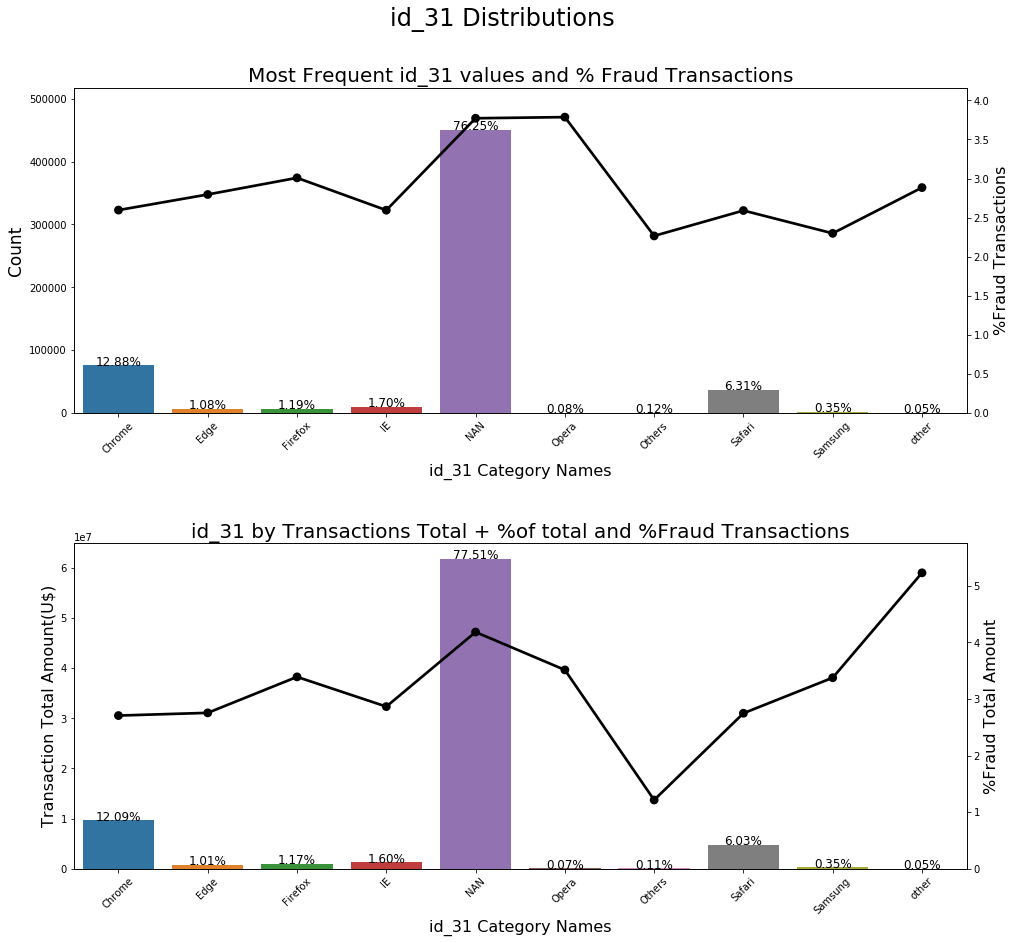

In [47]:
ploting_cnt_amt(df_train, 'id_31')